<a href="https://colab.research.google.com/github/KimSeonHo-719/CV/blob/main/%EA%B3%BC%EC%A0%9C5%266.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

In [14]:
!wget 'https://raw.githubusercontent.com/KimSeonHo-719/CV/main/gyujin.png' -O gyujin.png

--2025-04-06 07:49:48--  https://raw.githubusercontent.com/KimSeonHo-719/CV/main/gyujin.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222295 (217K) [image/png]
Saving to: ‘gyujin.png’

gyujin.png          100%[===================>] 217.08K  --.-KB/s    in 0.04s   

2025-04-06 07:49:48 (5.94 MB/s) - ‘gyujin.png’ saved [222295/222295]



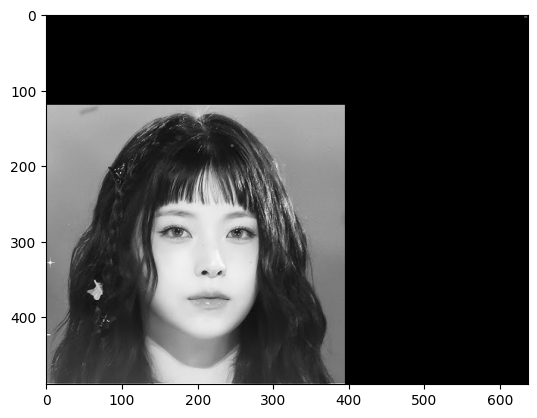

In [15]:
img_BGR=cv2.imread('/content/gyujin.png')
img_GRAY = cv2.cvtColor(img_BGR,cv2.COLOR_BGR2GRAY)
plt.imshow(img_GRAY,cmap='gray')

In [41]:
# Frequency domain에서 이미지 보기
def dft_image(img):
  # 2차원 FFT 계산 후, 중심으로 이동
  dft=np.fft.fft2(img)
  dft_shift=np.fft.fftshift(dft)
  return dft_shift
dft_shift=dft_image(img_GRAY)

def idft_image(dft_shift):
  # 중심 이동 역변환 후, 역 FFT 계산
  f_ishift=np.fft.ifftshift(dft_shift)
  img_back=np.fft.ifft2(f_ishift)
  img_back=np.abs(img_back)
  return img_back
idft_shift=idft_image(dft_shift)

# 주파수 스펙트럼의 로그 스케일(시각화를 위해)
magnitude_spectrum_DFT=20*np.log(np.abs(dft_shift)+1)
magnitude_spectrum_IDFT=20*np.log(np.abs(idft_shift)+1)

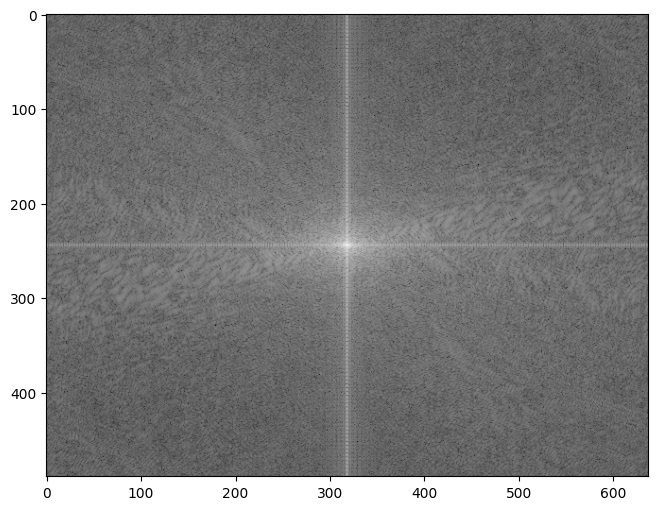

In [42]:
# DFT Visualization
plt.figure(figsize=(8,6))
plt.imshow(magnitude_spectrum_DFT, cmap='gray')

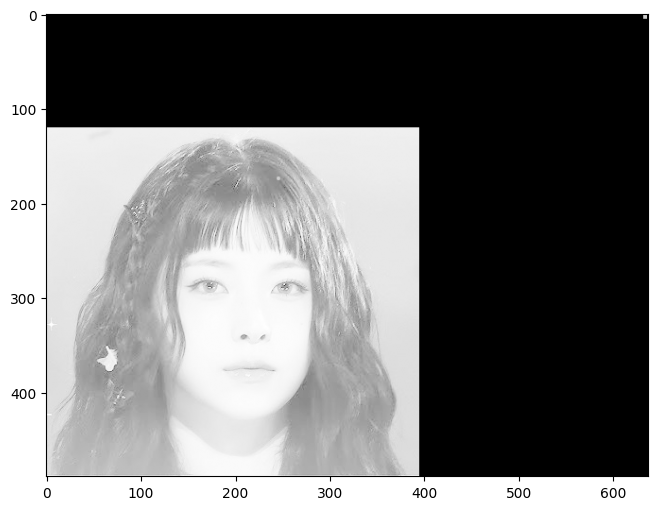

In [46]:
# IDFT Visualization - ERROR
# 원본에서 밝기를 최대화한 것처럼 바뀌었다.
# 원인으로는 정규화 방법에서 원본 이미지의 최대/최소값을 고려하지 않고 단순히 동적 범위만 맞춰서 이런 결과가 나온다고 한다. - ChatGPT
## => 정규화 범위가 맞춰지지 않았다는 뜻으로 이해했다.
# 또한 주파수 스펙트럼은 로그 스케일로 변환하여 시각화하지만 spatial domain에서는 로그 스케일 변환을 고려하지 않기 때문이다. - ChatGPT
plt.figure(figsize=(8,6))
plt.imshow(magnitude_spectrum_IDFT, cmap='gray')

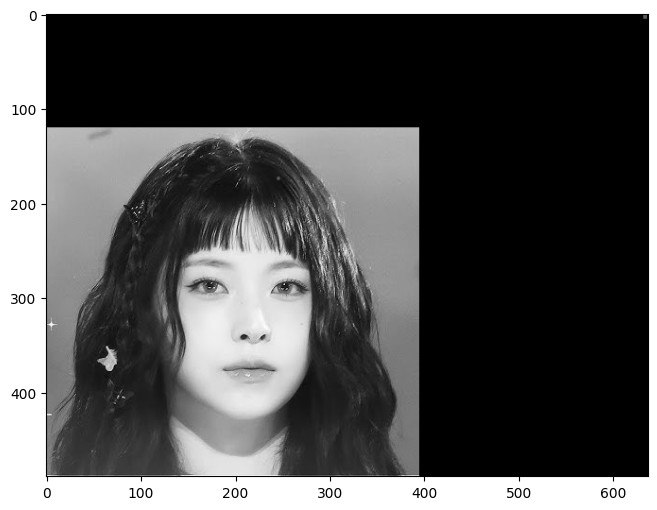

In [48]:
# 복원된 이미지 정규화 (0~255)
# 정규화 범위 0~255로 선형변환
# 최소 최대를 0, 255로 맞춰 이미지 데이터에 매핑하는 방식이다. - ChatGPT
# 입력 이미지 idft_shift의 최소, 최대값을 찾아서 각 픽셀에 대해 변환하여 매핑한 것으로 보인다.
img_back_norm = cv2.normalize(idft_shift, None, 0, 255, cv2.NORM_MINMAX)

plt.figure(figsize=(8,6))
plt.imshow(img_back_norm, cmap='gray')

In [58]:
# Low-pass Filter
# 3-1 디지털신호처리 시간에 생성했던 LowPassFilter를 바탕으로 코드를 생성했다.
# shape = 필터 적용할 주파수 스펙트럼 크기
def lowpassfilter(shape,threshold):
  r,c=shape

  # 주파수 스펙트럼 중앙좌표 => 푸리에 변환 결과 저주파 성분은 중앙으로 몰리고 고주파 성분은 코너로 몰리기 때문에.
  center_r,center_c=r//2,c//2
  y,x=np.ogrid[:r,:c]

  # 각 픽셀 중심에서 거리 계산
  d=np.sqrt((x-center_c)**2+(y-center_r)**2)

  mask=d<=threshold
  return mask

In [59]:
# High-pass Filter
# highpassfilter는 lowpassfilter 반대이므로 1에서 빼주면 됨
def highpassfilter(shape, threshold):
  return 1-lowpassfilter(shape,threshold)

In [64]:
# 임계값은 50으로 지정
threshold=50

# 필터 마스크를 이용하여 임계값과 필터 조건에 맞는 주파수 설정
lp=lowpassfilter(dft_shift.shape,threshold)
hp=highpassfilter(dft_shift.shape,threshold)

# 주파수 도메인에서 각 필터 적용
dft_lp=dft_shift*lp
dft_hp=dft_shift*hp

# 역변환으로 다시 변환
img_lp = idft_image(dft_lp)
img_hp = idft_image(dft_hp)

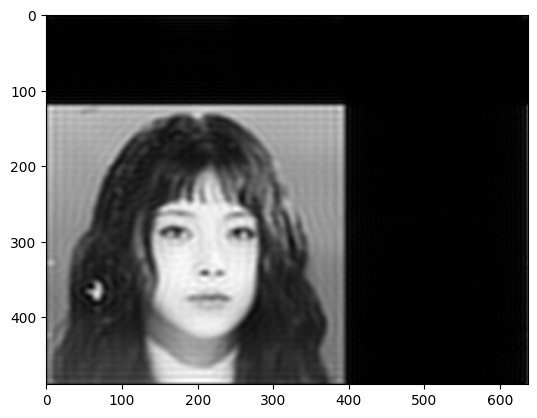

In [66]:
# Low_pass Filter 적용한 이미지
# 윤곽의 세밀함이 원본에 비해 떨어지고 흐릿하고 뭉툭한 느낌만 난다.
plt.imshow(img_lp, cmap='gray')

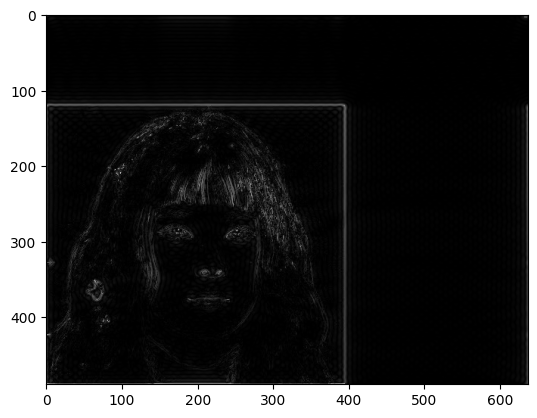

In [67]:
# High_pass Filter 적용한 이미지
# 얼굴 색상이나 질감은 전혀 보이지 않고 그림 그릴때 스케치한 결과만 뾰족하게 남은 것을 볼 수 있다.
plt.imshow(img_hp, cmap='gray')